In [1]:
# !pip install qutip
from qutip import *
from math import *
import itertools
from itertools import product
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

font = {'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 6, 4
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
 

# Exact diagonalization of fixed-point Hamiltonian

In [2]:
def imp_energy(Ek_0, V, J, K, U, ed):
    dim = len(Ek_0)
    ed = -U/2
    imp_ed_up = [create(2)*destroy(2), identity(2)]
    imp_ed_dn = [identity(2), create(2)*destroy(2)]
    imp_U = [create(2)*destroy(2), create(2)*destroy(2)]
    bath = [identity(2)]*2*dim
    return ed*tensor(imp_ed_up+bath) + ed*tensor(imp_ed_dn+bath) + U*tensor(imp_U+bath)


def kin_en(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            imp = [identity(2)]*2
            bef = [identity(2)]*2*i
            tau = create(2)*destroy(2) - 1/2
            curr = [Ek_0[i]*tau, identity(2)] if sigma == "u" else [identity(2), Ek_0[i]*tau]
            aft = [identity(2)]*2*(dim - i - 1)
            mats = imp+bef+curr+aft
            H += tensor(mats)
    return H


def hyb(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            tau = create(2)*destroy(2) - 1/2
            if sigma == "u":
                mats1 = [destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
            else:
                mats1 = [identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1)
            H += -tensor(mats1) + tensor(mats2)
    return V * H
    
    
def spin(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Sdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) - tensor(identity(2), create(2)*destroy(2)))
    Sdplus = tensor(create(2), destroy(2))
    Sdmin = -tensor(destroy(2), create(2))
    Ksz = Ksplus = Ksmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [create(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Ksz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksz += 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Ksplus -= tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*j + [create(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Ksplus += tensor([idt]*2*i + [create(2), destroy(2)] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*i + [destroy(2), create(2)] + [idt]*2*(dim - i - 1))

    return J * (tensor(Sdz, Ksz) + 0.5*tensor(Sdplus, Ksmin) + 0.5*tensor(Sdmin, Ksplus))


def charge(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Cdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) + tensor(identity(2), create(2)*destroy(2)) - 1)
    Cdplus = tensor(create(2), create(2))
    Cdmin = -tensor(destroy(2), destroy(2))
    Kcz = -dim/2
    Kcplus = Kcmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Kcplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, create(2)] + [idt]*2*(dim - j - 1))
            Kcmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Kcz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcz -= 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Kcplus -= tensor([idt]*2*j + [idt, create(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Kcplus += tensor([idt]*2*i + [create(2), create(2)] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*i + [destroy(2), destroy(2)] + [idt]*2*(dim - i - 1))

    return K * (tensor(Cdz, Kcz) + 0.5*tensor(Cdplus, Kcmin) + 0.5*tensor(Cdmin, Kcplus))

# Spectral Function

## $T=0$

100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


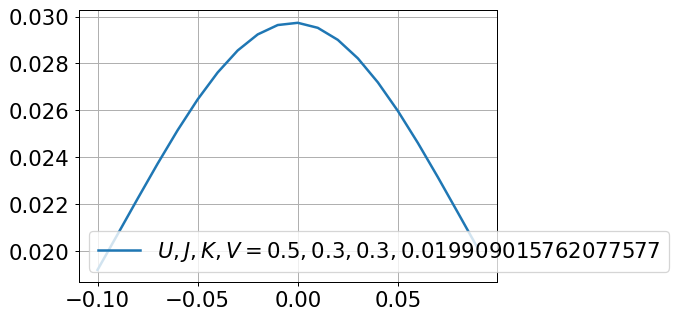

100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


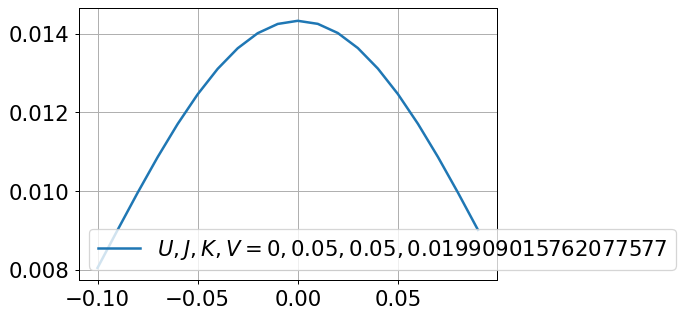

In [8]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp], U = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp_1 = Xm.dag()*cdag_up*Xmp
    Vmmp_2 = Xmp.dag()*cdag_up*Xm
    Vmmp_1_sq = np.real((Vmmp_1*Vmmp_1.dag())[0][0][0])
    Vmmp_2_sq = np.real((Vmmp_2*Vmmp_2.dag())[0][0][0])
    x1 = w + Em
    x2 = w - Em
    eta = abs(max(Ek_0))      # width of broadening function
    return (Vmmp_1_sq * sqrt(2*J**2 + U**2)*exp(-(x1/eta)**2)/(eta*sqrt(pi)) + Vmmp_2_sq * sqrt(2*J**2 + U**2)*exp(-(x2/eta)**2)/(eta*sqrt(pi))) / Z

Ek_0 = np.array([-0.1, 0, 0.1])
# print (Ek_0)
U = 0                      
# 0.5, 0.3, 0.2, 0.1, 0
ed = -U/2
V = 0.019909015762077577
# 0.019909015762077577
J = 0.05
# 0.3, 0.25, 0.2, 0.15, 0.05
K = J
# 0.3, 0.25, 0.2, 0.15, 0.05
for U, J in zip([0.5, 0], [0.3, 0.05]):
    K = J
    ed = -U/2
    H = kin_en(Ek_0, V, J, K, U, ed)
    H += imp_energy(Ek_0, V, J, K, U, ed)
    H += hyb(Ek_0, V, J, K, U, ed)
    H += spin(Ek_0, V, J, K, U, ed)
    H += charge(Ek_0, V, J, K, U, ed)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    E = np.array(E)
    zeroE = E[np.where(np.abs(np.round(E,9)) == 0)]
    zeroX = X[np.where(np.abs(np.round(E,9)) == 0)]
    Z = len(E)
    w_range = np.arange(-0.1, 0.1, 0.01)
    rho = []
    for w in tqdm(w_range):
        rho_w = sum(Pool(processes=10).map(rho_at_w, zip(product(E, zeroE), product(X, zeroX), U*np.ones(len(E)*len(zeroE)))))
        rho.append(rho_w)
        # for [Em, Emp],[Xm,Xmp] in zip(product(E, E), product(X, X)):
        #     cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
        #     Vmmp = Xm.dag()*cdag_up*Xmp
        #     Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
        #     x = w - Emp + Em
        #     eta = Ek_0[-1]      # width of broadening function
        #     rho[-1] += Vmmp_sq * exp(-(x/w)**2)/(w*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z    

    plt.plot(w_range, rho, label=r"$U,J,K,V={},{},{},{}$".format(U, J, K, V))    
    plt.legend()
    plt.show()

In [24]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp] = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp = Xm.dag()*cdag_up*Xmp
    Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    x = w - Emp + Em
    eta = abs(max(Ek_0))      # width of broadening function
    return Vmmp_sq * exp(-(x/eta)**2)/(eta*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z

Ek_0 = np.array([-0.2, -0.1, 0.1, 0.2])
# print (Ek_0)
U = 0.1
V = 0.019909015762077577
J = 0.015838964056748835
K = J
plt.rcParams["figure.figsize"]= 12, 4
H = kin_en(Ek_0, V, J, K, U)
# H += imp_energy(Ek_0, V, J, K, U)
H += hyb(Ek_0, V, J, K, U)
H += spin(Ek_0, V, J, K, U)
H += charge(Ek_0, V, J, K, U)
H = 0.5 * (H + H.dag())
E, X = H.eigenstates()
# E = np.array(E)
T = 0.1
kb = 1
beta = 1/(kb*T)
Z = sum(np.exp(-beta*E))
w_range = np.arange(-2, 2, 0.1)
rho = []
for w in tqdm(w_range):
    rho_w = sum(Pool(processes=10).map(rho_at_w, zip(product(E, E), product(X, X))))
    rho.append(rho_w)
    # for [Em, Emp],[Xm,Xmp] in zip(product(E, E), product(X, X)):
    #     cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    #     Vmmp = Xm.dag()*cdag_up*Xmp
    #     Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    #     x = w - Emp + Em
    #     eta = Ek_0[-1]      # width of broadening function
    #     rho[-1] += Vmmp_sq * exp(-(x/w)**2)/(w*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z    

plt.plot(w_range, rho)
plt.show()

TypeError: kin_en() missing 1 required positional argument: 'ed'